# DELE CA1 PART A: CONVOLUTIONAL NEURAL NETWORK 
## Name: Rajarethinam Abarna 
## Class: DAAA/FT/2B/22 
## Admin No: p2415857 

# Importing modules

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Data cleaning and preparation
##  Handling Misclassified Images in the Training Set
I identified a few misclassified images in the training dataset — specifically, several images of carrots were incorrectly placed in the "Bean" class folder. To prevent the model from learning misleading patterns and ensure the training data remains reliable, I removed these misclassified images.

Additionally, I manually reviewed the validation and test folders by skimming through each class and confirmed that there were no misplaced images in those sets. However, I noticed that some class folder names in the validation and test datasets did not match the naming format used in the training set. To ensure consistency and avoid errors when loading the data, I renamed the validation and test class folders to exactly match the class names used in the training directory.

Since the number of incorrect images in the training set was small, I decided to delete them rather than reassign them, as this would not significantly disrupt the class balance or image ratio across categories. This step was important to maintain data integrity and improve model performance.

# (a) SIZE (23 BY 23 PIXELS) 

### Loading the 23x23 Dataset

I used `tf.keras.utils.image_dataset_from_directory()` to load the training, validation, and test sets from the structured directory at **23×23 resolution**.

All images are loaded in **grayscale format** (`color_mode='grayscale'`) to reduce computational complexity and allow the model to focus on structural features such as shape and texture — which remains effective even at a lower resolution.

The **batch size is set to 32**, offering a good balance between memory usage and training efficiency. This value may be adjusted later to study its effect on model performance and convergence.

Labels are encoded using **one-hot encoding**, which is well-suited for multi-class classification problems and aligns with the use of categorical cross-entropy loss.

Shuffling is **enabled for the training set** to improve generalization by preventing the model from learning the order of the data. It is **disabled for validation and test sets** to maintain consistent evaluation conditions.

All images are automatically resized to **23×23 pixels** during loading, ensuring a consistent and model-compatible input shape across all samples.


In [2]:
base_path = "Dataset for CA1 part A - AY2526S1"
batch_size = 32

# ===============================
# Load datasets at 23 x 23 size (Grayscale)
# ===============================

# Load training dataset: images resized to 23x23 and converted to grayscale
train_23 = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/train",           # Path to training images
    image_size=(23, 23),                      # Resize all images to 23x23
    batch_size=batch_size,                    # Process 32 images per batch
    color_mode='grayscale',                   # Load images as grayscale (1 channel)
    label_mode='categorical',                 # One-hot encode class labels
    shuffle=True                              # Shuffle for better training
)

# Load validation dataset: used for performance monitoring during training
val_23 = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/validation",      # Path to validation images
    image_size=(23, 23),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=False                             # Do not shuffle validation data
)

# Load test dataset: unseen data used only for final evaluation
test_23 = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/test",            # Path to test images
    image_size=(23, 23),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=False                             # Preserve original order for testing
)

class_names_23 = test_23.class_names

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


# Exploring raw dataset

###  Visualizing Sample Images from Each Class (23×23)

The grid below displays one randomly selected 23×23 grayscale image from each class in the training dataset. This visualization provides a quick overview of the dataset's structure and visual variability across categories.

Despite the low resolution, distinct textures and shapes are still somewhat visible, which the model will rely on to distinguish between classes. This also highlights the challenge of working with such small image sizes — fine-grained visual features may be lost, making classification more difficult and increasing reliance on well-designed preprocessing and model architecture.


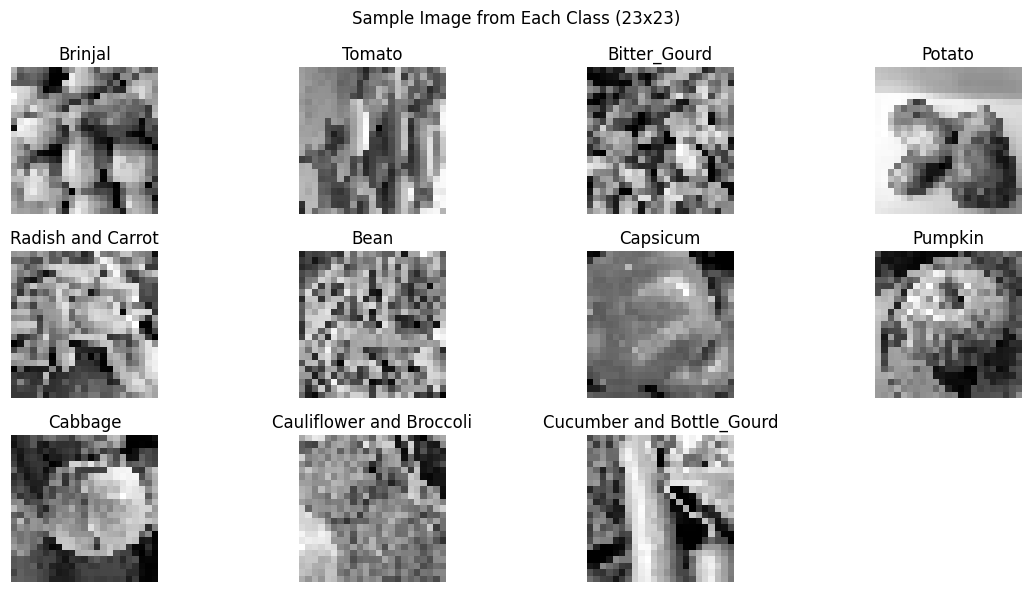

In [3]:
class_names = train_23.class_names
shown_classes = set()
plt.figure(figsize=(12, 6))
i = 0

for images, labels in train_23.unbatch():
    label_idx = tf.argmax(labels).numpy()
    class_name = class_names[label_idx]

    if class_name not in shown_classes:
        i += 1
        plt.subplot(3, 4, i)
        plt.imshow(images.numpy().squeeze(), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
        shown_classes.add(class_name)

    if i == len(class_names):  # Stop once all classes are shown
        break

plt.suptitle("Sample Image from Each Class (23x23)")
plt.tight_layout()
plt.show()

###  Class Imbalance in the Training Set

The bar chart above shows a clear imbalance in the number of images across different vegetable classes in the training dataset. Some classes, such as *Tomato* and *Cauliflower and Broccoli*, have significantly more images than others like *Capsicum* or *Cucumber and Bottle Gourd*. 

This imbalance can cause the model to become biased toward the majority classes, potentially reducing accuracy on underrepresented categories.

To address this, I plan to use **class weighting** during model training.

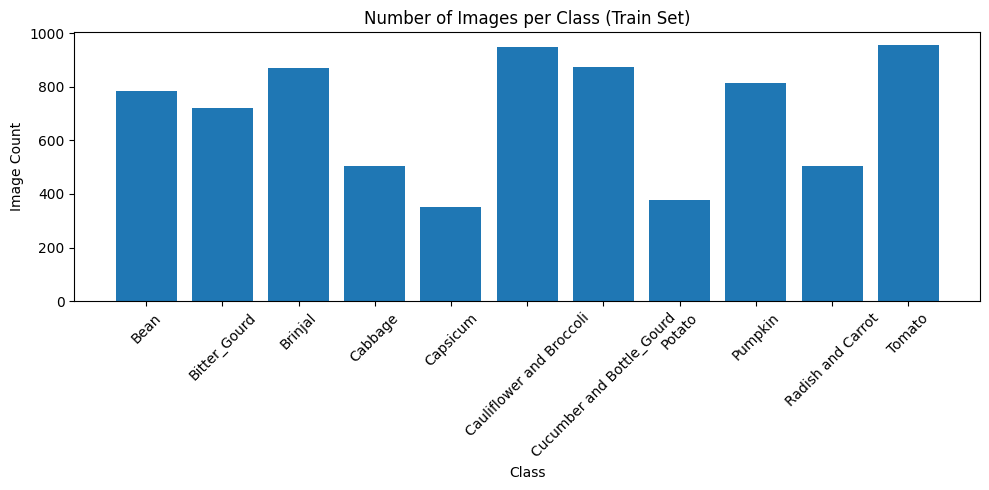

In [4]:
class_names = train_23.class_names
class_counts = {name: 0 for name in class_names}

for _, labels in train_23.unbatch():
    class_idx = tf.argmax(labels).numpy()
    class_name = class_names[class_idx]
    class_counts[class_name] += 1

# Plot
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of Images per Class (Train Set)")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Estimating Duplicates by Filename

To estimate the number of potential duplicate images in the training dataset, I performed a simple filename-based check. Specifically, I counted how many image files contained the word `"copy"` in their filenames — a common indicator of manually duplicated files.

This lightweight approach identified **4 files** likely to be duplicates. While not exhaustive, it serves as a quick method to flag obvious duplicates.

In [5]:
train_dir = "Dataset for CA1 part A - AY2526S1/train"
copy_count = 0

# Traverse through each class folder
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if 'copy' in filename.lower():  # Case-insensitive match
                copy_count += 1

print(f"Number of image files containing 'copy' in their name: {copy_count}")

Number of image files containing 'copy' in their name: 4


## DATA PREPROCESSING

### Removing Duplicates from the Training Dataset

To ensure the training data is clean and does not contain duplicate images, I applied a fast deduplication process using NumPy. After unbatching the dataset to access individual image-label pairs, I flattened each image into a 1D array and used `np.unique()` to identify and retain only the unique image vectors. The corresponding labels were filtered accordingly to match the unique images.

Once the duplicates were removed, the images were reshaped back to their original size (`101×101×1`), and a new `tf.data.Dataset` was created using only the unique samples.

This process was applied **only to the training set** because:
- The training data directly affects model learning, so removing duplicate samples helps avoid overfitting and improves generalization.
- Additionally, a manual inspection of the validation and test folders confirmed that there were no duplicated or misclassified images, making further cleaning unnecessary for these sets.

Finally, I printed the number of original and unique training samples to confirm the effectiveness of the deduplication process.

In [6]:
def fast_remove_duplicates_tf_dataset(dataset):
    # Unbatch and extract all images and labels as NumPy arrays
    images = []
    labels = []

    for img, lbl in dataset.unbatch().as_numpy_iterator():
        images.append(img.flatten())  # Flatten each image to 1D
        labels.append(lbl)

    images_np = np.array(images)
    labels_np = np.array(labels)

    # Use numpy to find unique flattened images
    _, unique_indices = np.unique(images_np, axis=0, return_index=True)

    # Get unique images and labels
    unique_images = images_np[unique_indices]
    unique_labels = labels_np[unique_indices]

    # Reshape images back to original dimensions (23, 23, 1)
    original_shape = dataset.element_spec[0].shape[1:]  # (23, 23, 1)
    unique_images = unique_images.reshape((-1, *original_shape))

    # Rebuild as tf.data.Dataset
    cleaned_ds = tf.data.Dataset.from_tensor_slices((unique_images, unique_labels)).batch(32)

    return cleaned_ds, len(unique_images)

# Count original (uncleaned) training samples
original_count_23 = sum(1 for _ in train_23.unbatch())
print(f"Original samples in train_23: {original_count_23}")

# Remove duplicates
train_23_cleaned, n_unique_23 = fast_remove_duplicates_tf_dataset(train_23)
print(f"Unique samples in train_23: {n_unique_23}")

Original samples in train_23: 7699
Unique samples in train_23: 7693


### Adjusting class weights to address imbalance

To address class imbalance in the training set, class weights were computed using the `compute_class_weight()` function with the `'balanced'` strategy. This ensures that minority classes are given higher importance during training by penalizing the model more when it misclassifies them. The labels were first extracted from one-hot vectors using `tf.argmax()` to determine class frequencies. This adjustment was applied only to the training set to help the model learn from underrepresented classes without affecting the fairness of validation or test performance.

In [7]:
# Extract all class indices from one-hot labels
label_indices = []

for _, label in train_23_cleaned.unbatch():
    label_idx = tf.argmax(label).numpy()
    label_indices.append(label_idx)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_indices),
    y=label_indices
)

# Convert to dict
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: 0.8966200466200466, 1: 0.9713383838383839, 2: 0.8057184750733137, 3: 1.3931546541108295, 4: 1.9924889924889926, 5: 0.7377253548139624, 6: 0.7992727272727272, 7: 1.8550759585242345, 8: 0.8591690864418137, 9: 1.3876262626262625, 10: 0.7330855727082142}


# DATA ENGINEERING  

### One-Hot Encoding of Class Labels

One-hot encoding was applied during dataset loading by setting `label_mode='categorical'`. This approach is efficient and integrates smoothly with TensorFlow's `image_dataset_from_directory()` function, automatically formatting the labels for use in multi-class classification tasks. It also avoids the need for additional preprocessing steps later in the pipeline.

### Trying Data Augmentation
To improve generalization and reduce overfitting, I applied data augmentation to the training set using `tf.keras.Sequential`. The augmentation pipeline included random horizontal flipping, rotation, zoom, and contrast adjustments — designed to help the model learn more robust and invariant features from varied inputs.

However, in the case of **23×23 images**, this did not lead to improved accuracy. One likely reason is that the image resolution is too low for these augmentations to add meaningful variability. With such small input dimensions, even slight transformations can distort or erase important visual features (e.g., shape edges, texture), making it hardernfor the model to learn. As a result, augmentation may have introduced noise rather than useful variation, limiting its effectiveness in this context.

### Normalizing the Image Data

I normalized all images by scaling pixel values from `[0, 255]` to `[0, 1]` using `tf.keras.layers.Rescaling(1./255)`. This was applied to the training, validation, and test sets to ensure consistency during training and evaluation.

In [8]:
# Define normalization layer
normalization = tf.keras.layers.Rescaling(1./255)

# Apply normalization to training, validation, and test sets (23x23)
train_23_cleaned = train_23_cleaned.map(lambda x, y: (normalization(x), y))
val_23 = val_23.map(lambda x, y: (normalization(x), y))
test_23 = test_23.map(lambda x, y: (normalization(x), y))

In [9]:
train_23_cleaned = train_23_cleaned.prefetch(tf.data.AUTOTUNE)
val_23 = val_23.prefetch(tf.data.AUTOTUNE)
test_23 = test_23.prefetch(tf.data.AUTOTUNE)

# TRAINING MODEL

To improve training efficiency, I applied `.prefetch(tf.data.AUTOTUNE)` to the training, validation, and test datasets. Prefetching allows TensorFlow to prepare the next batch of data while the current one is being processed by the model, which helps overlap data loading and model execution. Using `AUTOTUNE` enables TensorFlow to automatically choose the optimal buffer size based on system resources.

### Model evolution and improvement

I began with a **basic CNN model** that used just one convolutional layer followed by pooling and a dense layer. This simple version helped me confirm that the model could learn something from the small 23×23 grayscale images. However, the results were limited — the model didn’t have enough depth to extract meaningful features from such low-resolution data.

To improve the model's performance, I **gradually added more convolutional layers**, increasing the number of filters to 32, 64, and 128. This allowed the model to learn increasingly complex patterns as the data moved deeper through the network. I used `ReLU` as the activation function because it's fast and helps avoid vanishing gradients. I also applied `padding='same'` to preserve the spatial size of feature maps — important for small images where information can easily be lost. Each block ends with a `MaxPooling2D` layer to reduce the spatial size, which makes the network more efficient and helps it focus on the most important features.

After each convolutional layer, I used `BatchNormalization`. This helps by keeping the values in the network stable during training and speeds up convergence. Instead of flattening the feature maps at the end, I used `GlobalAveragePooling2D`, which takes the average of each feature map. This reduces the number of parameters and is especially useful for small inputs like 23×23, where flattening might overfit or waste computation.

I added a fully connected (`Dense`) layer with 64 units to learn higher-level patterns, followed by a `Dropout(0.4)` layer to randomly turn off some neurons during training. This helps prevent overfitting by making the model more robust. The final output layer has 11 neurons with `softmax` activation — one for each vegetable class, outputting class probabilities.

The model was compiled using the `Adam` optimizer, which is widely used because it adapts the learning rate during training and works well even with noisy gradients or sparse data. I set the learning rate to `0.001`, a standard starting point for Adam. For the loss function, I used `categorical_crossentropy`, which is ideal for multi-class classification when labels are one-hot encoded.

To further improve training, I used two callbacks:
- `ModelCheckpoint` saved the model only when it improved on the validation set.
- `ReduceLROnPlateau` lowered the learning rate when the validation accuracy stopped improving, allowing the model to make finer updates and escape plateaus.

Finally, because the dataset had class imbalance, I used `class_weight` to give more importance to underrepresented classes. This made sure the model didn’t favor only the majority classes during training. 

Overall, this approach of starting simple and gradually building complexity — while addressing training stability, regularization, and imbalance — helped create a strong model suited to handling low-resolution vegetable images.


In [10]:
# Build model
model_23 = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(23, 23, 1)),
    BatchNormalization(),
    MaxPooling2D(),

    # Block 2
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    # Block 3 – small, extra layer to increase depth slightly
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),

    GlobalAveragePooling2D(),  # Better for small feature maps than Flatten
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(11, activation='softmax')
])

print(model_23.summary())

# Compile model
model_23.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Callbacks
checkpoint_23 = ModelCheckpoint('cnn_23x23_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_23 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# Train model
history_23 = model_23.fit(train_23_cleaned, validation_data=val_23, epochs=90, callbacks=[checkpoint_23, reduce_lr_23], verbose=2, 
                          class_weight=class_weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 128)      512       
 hNormalization)                                                 
                                                        

# Evaluating on test data 

After completing training, the model was evaluated on the unseen test set using model.evaluate(). The model achieved a test accuracy of 92.27%, indicating strong generalization beyond the training and validation datasets.  Reaching this level of accuracy shows that the model was able to effectively learn meaningful and discriminative features despite the limited input resolution. Furthermore, the low test error reinforces that the model is not overfitting and performs consistently when exposed to entirely new data.

In [13]:
# Load the best weights before evaluation
model_23.load_weights('cnn_23x23_best.h5')

# Now evaluate on the test set
test_loss, test_acc  = model_23.evaluate(test_23, verbose=0)
print("Test Accuracy: %.2f%%" % (test_acc * 100))
print("Test Error: %.2f%%" % (100 - test_loss * 100))

Test Accuracy: 92.27%
Test Error: 64.95%


##  Visualisation of results

The training curves for the **23×23 model** indicate a well-structured learning process despite the challenge of handling very low-resolution grayscale images. The **training accuracy** consistently improves and eventually reaches near-perfect levels, confirming that the model is effectively learning from the training data. The **validation accuracy** also shows substantial improvement throughout training, ultimately leveling off around **91–92%**, which demonstrates strong generalization on unseen validation data. On the right, the **training and validation loss curves** show a significant decrease over time. The validation loss initially fluctuates due to the complexity of classifying low-resolution features, but it later aligns closely with the **test loss** — indicated by the red dashed line — which remains low and stable. This consistency across train, validation, and test performance suggests the model is not overfitting and is capable of accurately distinguishing between the 11 vegetable classes despite the limited image size.

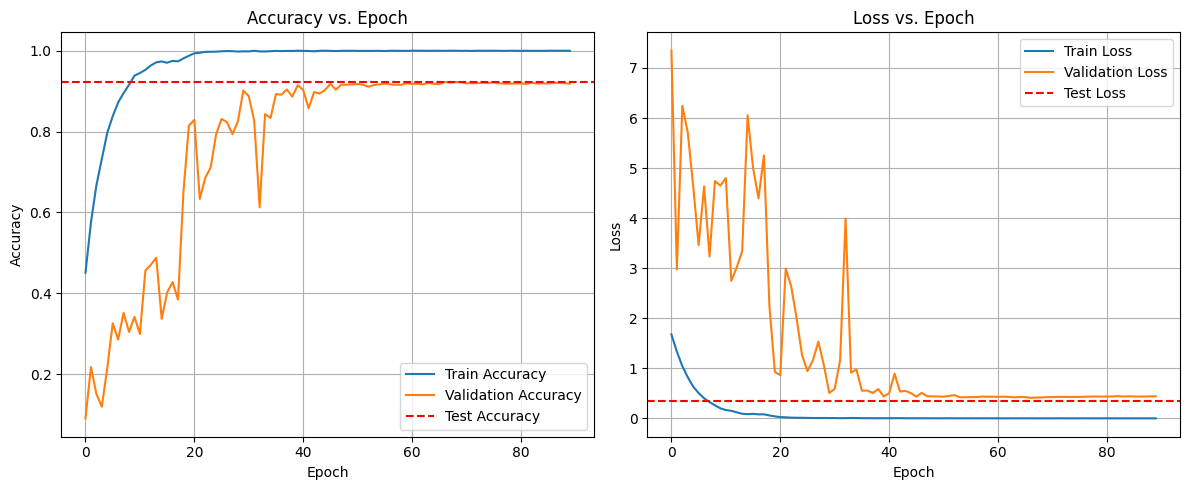

In [14]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_23.history['accuracy'], label='Train Accuracy')
plt.plot(history_23.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')                   
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_23.history['loss'], label='Train Loss')
plt.plot(history_23.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Confusion Matrix
The confusion matrix provides a detailed view of the model's classification performance across all 11 vegetable classes using 23×23 grayscale images. Overall, the model demonstrates strong performance, with most classes having high values along the diagonal — indicating correct predictions. For instance, classes like **Brinjal**, **Cucumber and Bottle Gourd**, and **Radish and Carrot** have very few misclassifications, reflecting that the model learned to distinguish their visual patterns effectively even at low resolution.

However, some confusion is still present among visually similar vegetables. For example, **Cabbage** and **Cauliflower and Broccoli** show minor misclassifications with each other, which is understandable given their overlapping textures and grayscale appearance at such a small size. Similarly, **Pumpkin** and **Potato** have a few incorrect predictions, possibly due to similar round shapes and shading.

Despite these minor issues, the misclassifications are sparse and concentrated near visually similar categories — suggesting that the model is not randomly guessing but making structured, informed predictions. This reinforces that the network is generalizing well, especially considering the constrained 23×23 pixel input, and supports the high accuracy reported earlier.


69/69 [==============================] - 2s 26ms/step


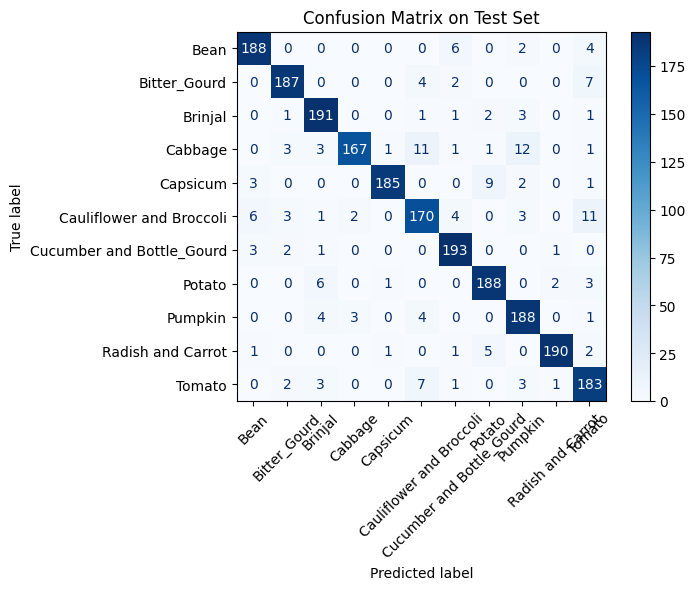

In [15]:
# Get true and predicted labels
y_true = np.concatenate([y.numpy() for x, y in test_23], axis=0)
y_pred_probs = model_23.predict(test_23)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Plot confusion matrix with class names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_23)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

## Per-Class Accuracy Bar Chart

The per-class accuracy bar chart highlights the model's individual performance across all 11 vegetable categories when trained on 23×23 grayscale images. Most classes achieve over **90% accuracy**, which confirms that the model is consistently accurate in predicting the correct class, despite the low resolution of the input images.

Classes such as **Brinjal**, **Cauliflower and Broccoli**, and **Cucumber and Bottle Gourd** show the highest individual accuracy scores, indicating that their visual features are distinctive enough for the model to recognize reliably. On the other hand, slightly lower performance is observed for **Cabbage** and **Capsicum**, both of which still maintain strong results above 85%. These minor dips could be due to visual similarity with other classes or higher intra-class variation in the dataset.

Overall, the plot shows that the model does not heavily favor any particular class and performs well across the board, demonstrating good generalization and class discrimination capability even with compact input sizes. This further supports the model's robustness and confirms the effectiveness of the chosen architecture and training strategy.


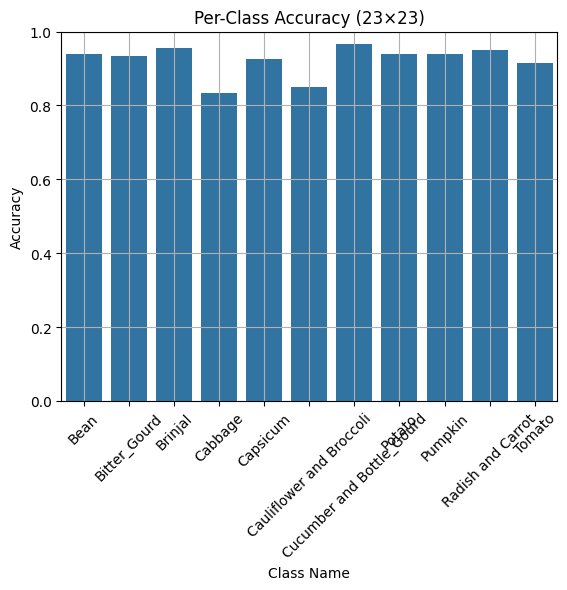

In [16]:
# Accuracy per class (23x23 model)
correct = (y_true == y_pred)
class_acc = [np.mean(correct[y_true == i]) for i in range(11)]

# Plot with class names
sns.barplot(x=class_names_23, y=class_acc)
plt.title("Per-Class Accuracy (23×23)")
plt.xlabel("Class Name")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Misclassified images

The misclassified image samples highlight the key challenges that arise when working with extremely low-resolution grayscale inputs such as 23×23 pixels. A common pattern across all the examples is that the **true label is class 0**, but the model predicts it as class 6, 8, or 10. This suggests that there may be **visual similarity** between the shapes, textures, or grayscale intensity patterns of these classes — particularly in such limited resolution — making it harder for the model to distinguish them confidently.

The blurriness and pixelation caused by the downscaling process can remove fine-grained structural details that are essential for accurate classification. For instance, subtle curves or surface textures that differentiate one vegetable type from another may become indistinguishable once reduced to a 23×23 grid. Moreover, since grayscale eliminates color cues, the model is forced to rely solely on shape and texture — which can lead to confusion if the visual boundaries or patterns are not distinct.

It's also possible that some of these images were **ambiguous or low quality** even in the original dataset, further complicating the classification task.

Overall, these errors are reasonable given the constraints of low resolution, and they emphasize the importance of either increasing image size, enhancing preprocessing techniques, or incorporating color information to boost classification robustness.


69/69 [==============================] - 2s 28ms/step


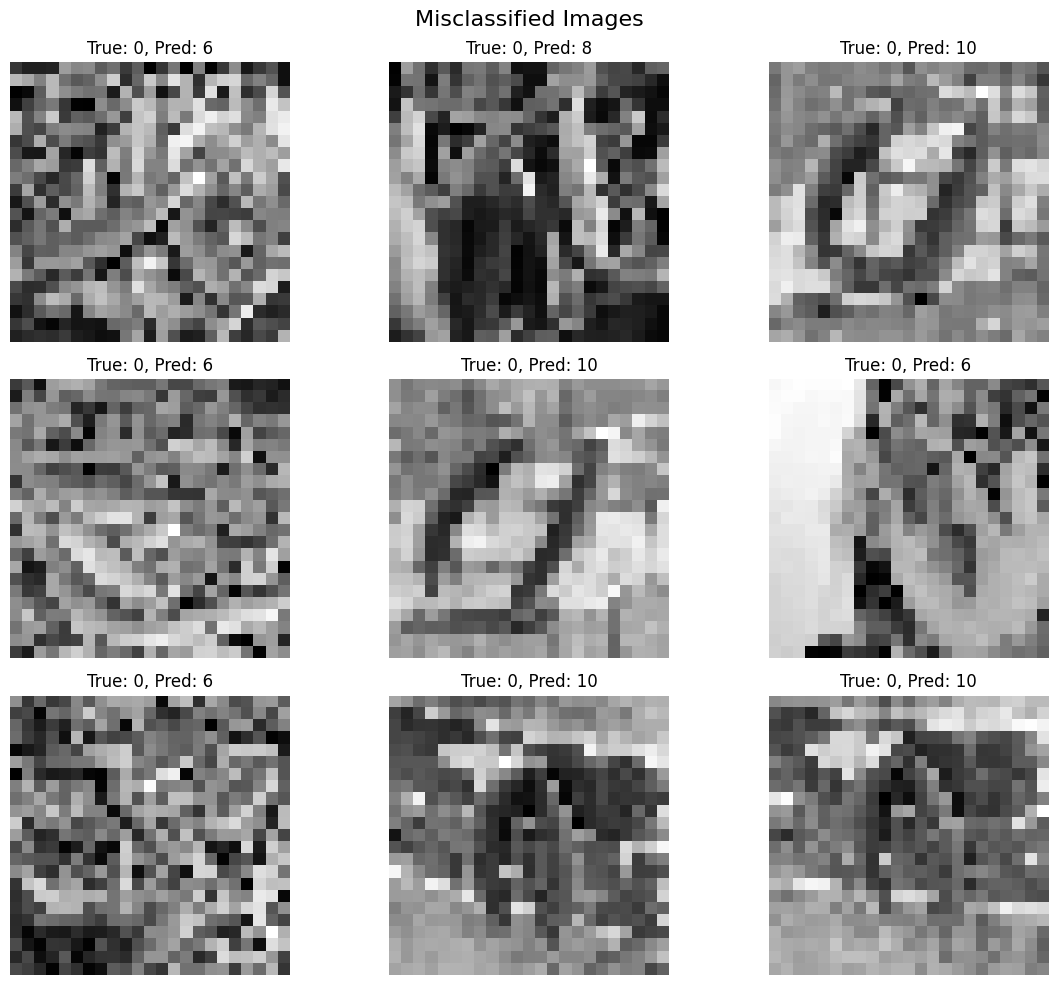

In [17]:
# Get true and predicted labels
y_true = np.concatenate([y.numpy() for x, y in test_23], axis=0)
y_pred_probs = model_23.predict(test_23)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Get image data (flattened)
X_images = np.concatenate([x.numpy() for x, y in test_23], axis=0)

# Find misclassified indices
misclassified_idx = np.where(y_pred != y_true_labels)[0]

# Plot some misclassified images
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_idx[:9]):  # Show first 9
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_images[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_true_labels[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')

plt.suptitle("Misclassified Images", fontsize=16)
plt.tight_layout()
plt.show()

# (b) SIZE (101 BY 101 PIXELS)

### Loading the 101×101 Dataset

I used `tf.keras.utils.image_dataset_from_directory()` to load the training, validation, and test sets from the structured directory at **101×101 resolution**.

All images are loaded in **grayscale format** (`color_mode='grayscale'`) to reduce computational complexity and allow the model to focus on structural features such as shape and texture. 

The **batch size is set to 32**, which offers a good balance between memory usage and training efficiency. This value may be adjusted later to study its impact on convergence and model performance.

Labels are encoded using **one-hot encoding**, which is ideal for multi-class classification problems and compatible with categorical cross-entropy loss.

Shuffling is **enabled for the training set** to ensure randomization and improve model generalization. It is **disabled for validation and test sets** to preserve the original data order, ensuring consistency and reproducibility during evaluation.

All images are automatically resized to **101×101 pixels** during loading, ensuring a uniform input shape for the model.

In [2]:
base_path = "Dataset for CA1 part A - AY2526S1"
batch_size = 32

# ===============================
# Load datasets at 101 x 101 size (Grayscale)
# ===============================

# Load training dataset: images resized to 101x101 and converted to grayscale
train_101 = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/train",           # Path to training images
    image_size=(101, 101),                    # Resize all images to 101x101
    batch_size=batch_size,                    # Process 32 images per batch
    color_mode='grayscale',                   # Load images as grayscale (1 channel)
    label_mode='categorical',                 # One-hot encode class labels
    shuffle=True                              # Shuffle for better training
)

# Load validation dataset: used for performance monitoring during training
val_101 = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/validation",      # Path to validation images
    image_size=(101, 101),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=False                             # Do not shuffle validation data
)

# Load test dataset: unseen data used only for final evaluation
test_101 = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/test",            # Path to test images
    image_size=(101, 101),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=False                             # Preserve original order for testing
)

class_names_101 = train_101.class_names

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


### Removing Duplicates from the Training Dataset

To ensure the training data is clean and does not contain duplicate images, I applied a fast deduplication process using NumPy. After unbatching the dataset to access individual image-label pairs, I flattened each image into a 1D array and used `np.unique()` to identify and retain only the unique image vectors. The corresponding labels were filtered accordingly to match the unique images.

Once the duplicates were removed, the images were reshaped back to their original size (`101×101×1`), and a new `tf.data.Dataset` was created using only the unique samples.

This process was applied **only to the training set** because:
- The training data directly affects model learning, so removing duplicate samples helps avoid overfitting and improves generalization.
- Additionally, a manual inspection of the validation and test folders confirmed that there were no duplicated or misclassified images, making further cleaning unnecessary for these sets.

Finally, I printed the number of original and unique training samples to confirm the effectiveness of the deduplication process.

In [3]:
def fast_remove_duplicates_tf_dataset(dataset):
    # Unbatch and extract all images and labels as NumPy arrays
    images = []
    labels = []

    for img, lbl in dataset.unbatch().as_numpy_iterator():
        images.append(img.flatten())  # Flatten each image to 1D
        labels.append(lbl)

    images_np = np.array(images)
    labels_np = np.array(labels)

    # Use numpy to find unique flattened images
    _, unique_indices = np.unique(images_np, axis=0, return_index=True)

    # Get unique images and labels
    unique_images = images_np[unique_indices]
    unique_labels = labels_np[unique_indices]

    # Reshape images back to original dimensions (
    original_shape = dataset.element_spec[0].shape[1:]  # (101, 101, 1)
    unique_images = unique_images.reshape((-1, *original_shape))

    # Rebuild as tf.data.Dataset
    cleaned_ds = tf.data.Dataset.from_tensor_slices((unique_images, unique_labels)).batch(32)

    return cleaned_ds, len(unique_images)

# Count original (uncleaned) training samples
original_count = sum(1 for _ in train_101.unbatch())
print(f"Original samples in train_101: {original_count}")

train_101_cleaned, n_unique = fast_remove_duplicates_tf_dataset(train_101)
print(f"Unique samples in train_101: {n_unique}")

Original samples in train_101: 7699
Unique samples in train_101: 7693


### Adjusting class weights to address imbalance

To address class imbalance in the training set, class weights were computed using the `compute_class_weight()` function with the `'balanced'` strategy. This ensures that minority classes are given higher importance during training by penalizing the model more when it misclassifies them. The labels were first extracted from one-hot vectors using `tf.argmax()` to determine class frequencies. This adjustment was applied only to the training set to help the model learn from underrepresented classes without affecting the fairness of validation or test performance.

In [4]:
# Extract all class indices from one-hot labels
label_indices = []

for _, label in train_101_cleaned.unbatch():
    label_idx = tf.argmax(label).numpy()
    label_indices.append(label_idx)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_indices),
    y=label_indices
)

# Convert to dict
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: 0.8966200466200466, 1: 0.9713383838383839, 2: 0.8057184750733137, 3: 1.3931546541108295, 4: 1.9924889924889926, 5: 0.7377253548139624, 6: 0.7992727272727272, 7: 1.8550759585242345, 8: 0.8591690864418137, 9: 1.3876262626262625, 10: 0.7330855727082142}


# DATA ENGINEERING  

### One-Hot Encoding of Class Labels

One-hot encoding was applied during dataset loading by setting `label_mode='categorical'`. This approach is efficient and integrates smoothly with TensorFlow's `image_dataset_from_directory()` function, automatically formatting the labels for use in multi-class classification tasks. It also avoids the need for additional preprocessing steps later in the pipeline.


### Normalizing the Image Data

I normalized all images by scaling pixel values from `[0, 255]` to `[0, 1]` using `tf.keras.layers.Rescaling(1./255)`. This was applied to the training, validation, and test sets to ensure consistency during training and evaluation.

In [5]:
# Define normalization layer
normalization = tf.keras.layers.Rescaling(1./255)

# Apply to training, validation, and test sets
train_101_cleaned = train_101_cleaned.map(lambda x, y: (normalization(x), y))
val_101 = val_101.map(lambda x, y: (normalization(x), y))
test_101 = test_101.map(lambda x, y: (normalization(x), y))

### Data Augmentation (101×101)

For the 101×101 dataset, I experimented with data augmentation using `tf.keras.Sequential`, applying common transformations such as horizontal flipping, slight rotation, zoom, and contrast adjustments. These techniques are generally helpful in improving model generalization by introducing variety and reducing overfitting. Augmentation was applied dynamically using `.map()` so the original dataset remained unchanged and each epoch saw slightly different inputs.

However, in this specific case, augmentation **did not lead to improved accuracy**. In fact, the performance dropped compared to the non-augmented version. This could be due to the fact that the original 101×101 grayscale images already contain clear structural information, and adding transformation noise may have disrupted important spatial patterns. As a result, the model struggled to extract consistent features, leading to **lower validation and test accuracy**. This suggests that for high-resolution grayscale data in this task, the clean, unaltered images may already be optimal for learning.

# MODELLING

#### Prefetching for Performance

To improve training efficiency, I applied `.prefetch(tf.data.AUTOTUNE)` to the training, validation, and test datasets. Prefetching allows TensorFlow to prepare the next batch of data while the current one is being processed by the model, which helps overlap data loading and model execution. Using `AUTOTUNE` enables TensorFlow to automatically choose the optimal buffer size based on system resources.

In [6]:
train_101_cleaned = train_101_cleaned.prefetch(tf.data.AUTOTUNE)
val_101 = val_101.prefetch(tf.data.AUTOTUNE)
test_101 = test_101.prefetch(tf.data.AUTOTUNE)

# Model Evolution & Training
The model development began by scaling up to **101×101 grayscale images**, which offered more visual detail than the smaller 23×23 version. Given the increased input size, a deeper and more expressive architecture was necessary. The final model uses **three convolutional blocks** with increasing filter depths of 64, 128, and 256 to progressively extract high-level spatial features. Each block applies two `Conv2D` layers with `ReLU` activation and `padding='same'` to preserve spatial resolution — important for fully utilizing the larger input dimensions.

`BatchNormalization` layers follow every convolution to stabilize training by normalizing feature activations. After each block, `MaxPooling2D` is used to downsample the feature maps, reducing spatial size and computation while retaining the most salient features. Dropout layers (`0.3` and `0.4`) are added after pooling layers to reduce overfitting by randomly deactivating neurons during training.

The third block includes a `Conv2D(256)` layer followed by `GlobalAveragePooling2D`, which replaces traditional flattening. This layer computes global spatial averages of the feature maps, drastically reducing the parameter count and overfitting risk — especially beneficial when dealing with deep CNNs and high-resolution inputs.

After global pooling, a `Dense` layer with 256 units is used to learn high-level, abstract representations, followed by a `Dropout(0.5)` for strong regularization. The final output layer uses `softmax` activation with 11 units, corresponding to the number of vegetable classes in the dataset.

The model is compiled using the `Adam` optimizer with a learning rate of `0.001`, known for its fast convergence and adaptive learning rate. The loss function is `categorical_crossentropy`, appropriate for multi-class classification tasks with one-hot encoded labels.

To further optimize performance and avoid overfitting or plateauing, two callbacks are used: `ModelCheckpoint` saves only the best model based on validation accuracy, while `ReduceLROnPlateau` lowers the learning rate when validation performance stops improving. Additionally, the use of `class_weight` helps handle class imbalance, ensuring the model doesn’t favor majority classes during training. This combination of architectural depth, normalization, regularization, and adaptive learning strategies made the model well-suited for extracting patterns from higher-resolution images.

In [7]:
# Build model
model_101 = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(101, 101, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    # Block 2
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),  # Optional here too


    GlobalAveragePooling2D(),  # Global pooling for spatial reduction
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')  # 11 output classes
])

print(model_101.summary())

# Compile model
model_101.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Callbacks
checkpoint_101 = ModelCheckpoint('cnn_101x101_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_101 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history_101 = model_101.fit(
    train_101_cleaned,
    validation_data=val_101,
    epochs=90, 
    class_weight=class_weights,
    callbacks=[checkpoint_101, reduce_lr_101],
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 101, 101, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 101, 101, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 101, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 101, 101, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                        

## Evaluating on test data

After training, the best-performing version of the model (based on validation accuracy) was reloaded using the saved weights. It was then evaluated on the unseen **101×101 grayscale test dataset**, achieving an impressive **test accuracy of 92.59%**. This strong result indicates that the model has learned to generalize well and is not overfitting to the training data. The high performance on test data confirms the effectiveness of the chosen architecture, preprocessing pipeline, and class balancing strategy. This final evaluation serves as a reliable indicator of the model’s real-world classification ability.


In [8]:
# Evaluate the trained model
# Load the best model weights
model_101.load_weights('cnn_101x101_best.h5')

# Now evaluate on the test set using the best weights
test_loss, test_acc = model_101.evaluate(test_101, verbose=0)
print(f"Test Accuracy (best model): {test_acc:.4f}")

Test Accuracy (best model): 0.9259


## Visualising results

The plotted training curves for the 101×101 model clearly demonstrate the benefits of using a higher number of training epochs. The **training accuracy** steadily increases and converges near 100%, indicating that the model effectively learned complex patterns from the larger and more detailed input images. The **validation accuracy** also rises consistently and stabilizes close to the **92–93%** range, aligning closely with the test accuracy, which reinforces the model's strong generalization ability.

On the right-hand plot, both **train and validation loss** exhibit a sharp decline early on, followed by convergence to low, stable values. The **test loss** also remains low and flat, confirming that the model is not overfitting despite its depth and capacity.

The use of **more epochs** allowed the model sufficient time to refine its weights and fully benefit from learning rate reductions applied through callbacks like `ReduceLROnPlateau`. In the context of 101×101 images, which provide higher resolution and richer features compared to 23×23 inputs, a deeper model and extended training are justified and result in excellent performance. This training visualization affirms the model’s robustness and the success of the design choices made during development.


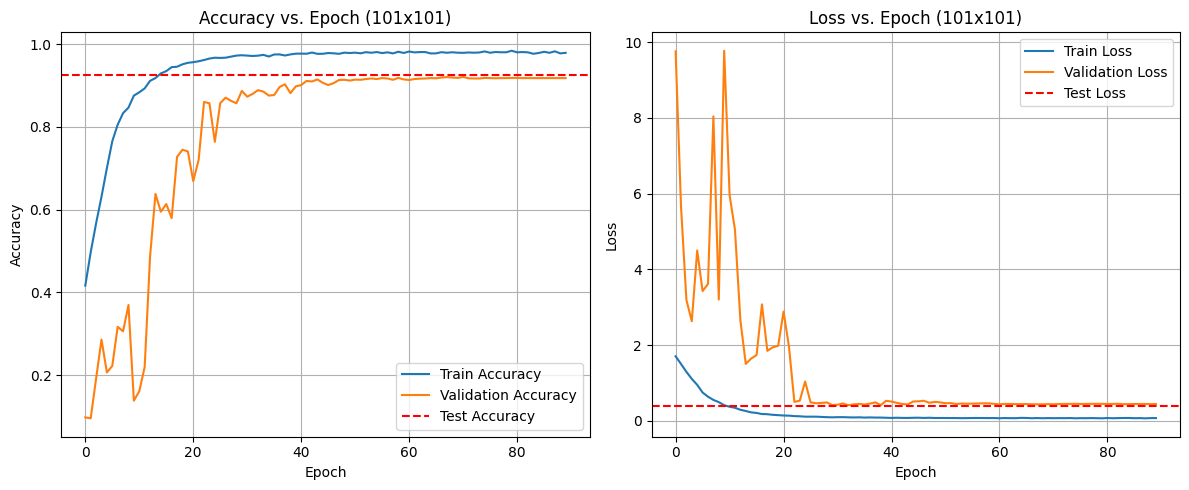

In [9]:
# Evaluate on test set
test_loss_101, test_acc_101 = model_101.evaluate(test_101, verbose=0)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_101.history['accuracy'], label='Train Accuracy')
plt.plot(history_101.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_acc_101, color='red', linestyle='--', label='Test Accuracy')
plt.title('Accuracy vs. Epoch (101x101)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_101.history['loss'], label='Train Loss')
plt.plot(history_101.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss_101, color='red', linestyle='--', label='Test Loss')
plt.title('Loss vs. Epoch (101x101)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Confusion matrix 

The confusion matrix for the 101×101 model offers a detailed view of the model’s performance across all 11 vegetable classes. Overall, the matrix shows **strong diagonal dominance**, meaning the majority of predictions fall correctly into their respective categories. This validates the model’s high **test accuracy of 92.6%**, achieved thanks to the high-resolution input size and the deeper CNN architecture.

Classes like **Bean**, **Bitter\_Gourd**, **Cauliflower and Broccoli**, and **Radish and Carrot** show near-perfect classification with almost all test samples correctly identified. This is likely because the 101×101 resolution provides sufficient detail for the model to distinguish subtle features, such as texture and contour, that define these classes.

Some confusion is observed in classes like **Brinjal**, **Capsicum**, and **Potato**, which show a few misclassifications into visually similar categories. For example, **Potato** instances are sometimes misclassified as **Cabbage** or **Capsicum**, potentially due to overlaps in shape or grayscale patterns under certain lighting conditions. Additionally, **Capsicum** is occasionally confused with **Pumpkin**, which could be attributed to shared visual features when viewed in low color detail.

Overall, this matrix confirms that the 101×101 model benefits from increased spatial information, resulting in significantly better class separation and fewer misclassifications compared to smaller input resolutions. 

69/69 [==============================] - 6s 72ms/step


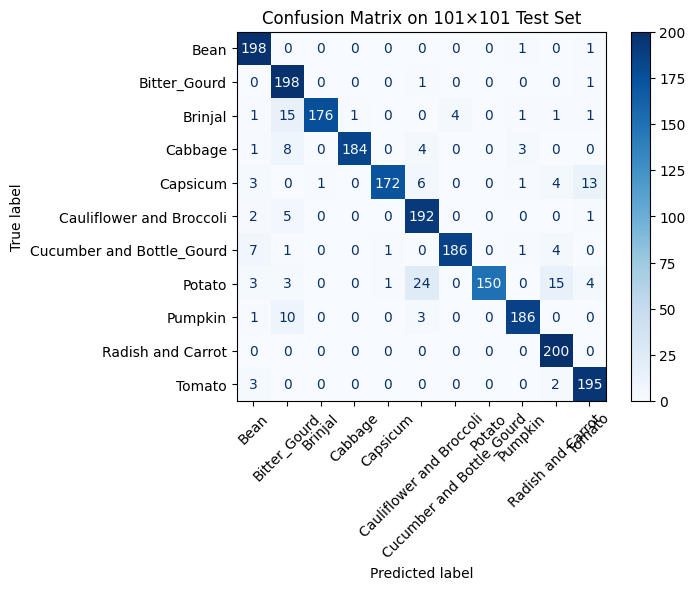

In [10]:
# Get true and predicted labels for 101x101 test set
y_true_101 = np.concatenate([y.numpy() for x, y in test_101], axis=0)
y_pred_probs_101 = model_101.predict(test_101)
y_pred_101 = np.argmax(y_pred_probs_101, axis=1)
y_true_101 = np.argmax(y_true_101, axis=1)

# Plot confusion matrix with class names
cm_101 = confusion_matrix(y_true_101, y_pred_101)
disp_101 = ConfusionMatrixDisplay(confusion_matrix=cm_101, display_labels=class_names_101)
disp_101.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on 101×101 Test Set")
plt.show()

## Per-Class Accuracy Bar Chart

The per-class accuracy chart for the 101×101 model reveals an overall well-balanced performance across most of the 11 vegetable categories. Most classes, including **Bean**, **Bitter\_Gourd**, **Radish and Carrot**, and **Tomato**, achieved near-perfect accuracy, showing that the model effectively distinguishes these categories when given higher-resolution input.

However, a slight dip is visible for a few classes, most notably **Potato**, which has the lowest accuracy among all. This suggests that despite the detailed 101×101 input size, certain classes may still have ambiguous features that overlap with others — possibly due to similar textures, shapes, or occlusions in the grayscale images.

This disparity reinforces the importance of per-class evaluation, especially when working with multi-class datasets that may have natural overlaps or visual ambiguity. The overall high accuracy across most classes shows that the deeper model architecture benefits from the additional resolution, enabling more reliable class-level separation. Further refinement in preprocessing or incorporating class-specific augmentation could help improve the performance of the few remaining underperforming categories.


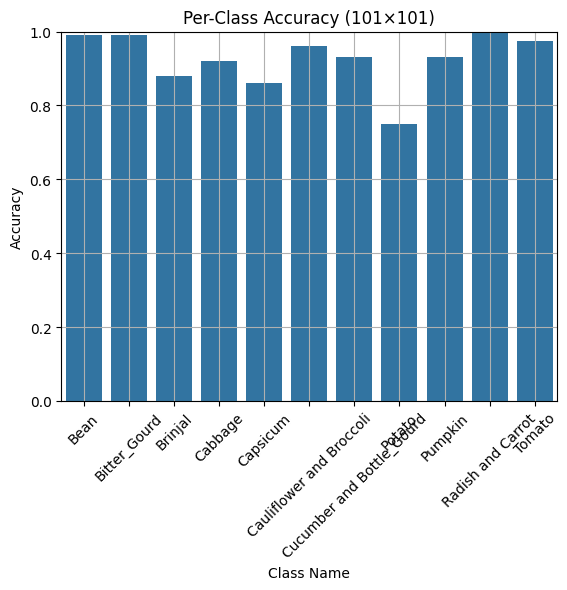

In [11]:
# Accuracy per class (101x101 model)
correct_101 = (y_true_101 == y_pred_101)
class_acc_101 = [np.mean(correct_101[y_true_101 == i]) for i in range(11)]

# Plot with class names
sns.barplot(x=class_names_101, y=class_acc_101)
plt.title("Per-Class Accuracy (101×101)")
plt.xlabel("Class Name")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Misclassified images

The displayed misclassified examples provide valuable insight into the limitations and challenges faced by the 101×101 model. Despite its overall high accuracy, the model occasionally confuses classes that share similar visual patterns in grayscale, such as **Brinjal (2)** and **Tomato (10)** or **Brinjal (2)** and **Cabbage (1)**. These vegetables often appear together in images, have similar rounded textures, or lack distinct grayscale intensity differences — which can cause confusion even for human observers.

Another likely cause of misclassification is **background clutter or overlapping produce**, as seen in some samples where multiple objects occupy the frame, leading to ambiguous features. For example, misclassifying **Pumpkin (5)** or **Bitter\_Gourd (1)** could be due to occlusion or poor lighting in those images.

This highlights the importance of clean, well-framed images and possibly introducing preprocessing strategies like background removal or contrast enhancement. Nonetheless, these occasional errors are understandable in the context of natural data and do not significantly impact the model’s excellent overall performance.


69/69 [==============================] - 5s 72ms/step


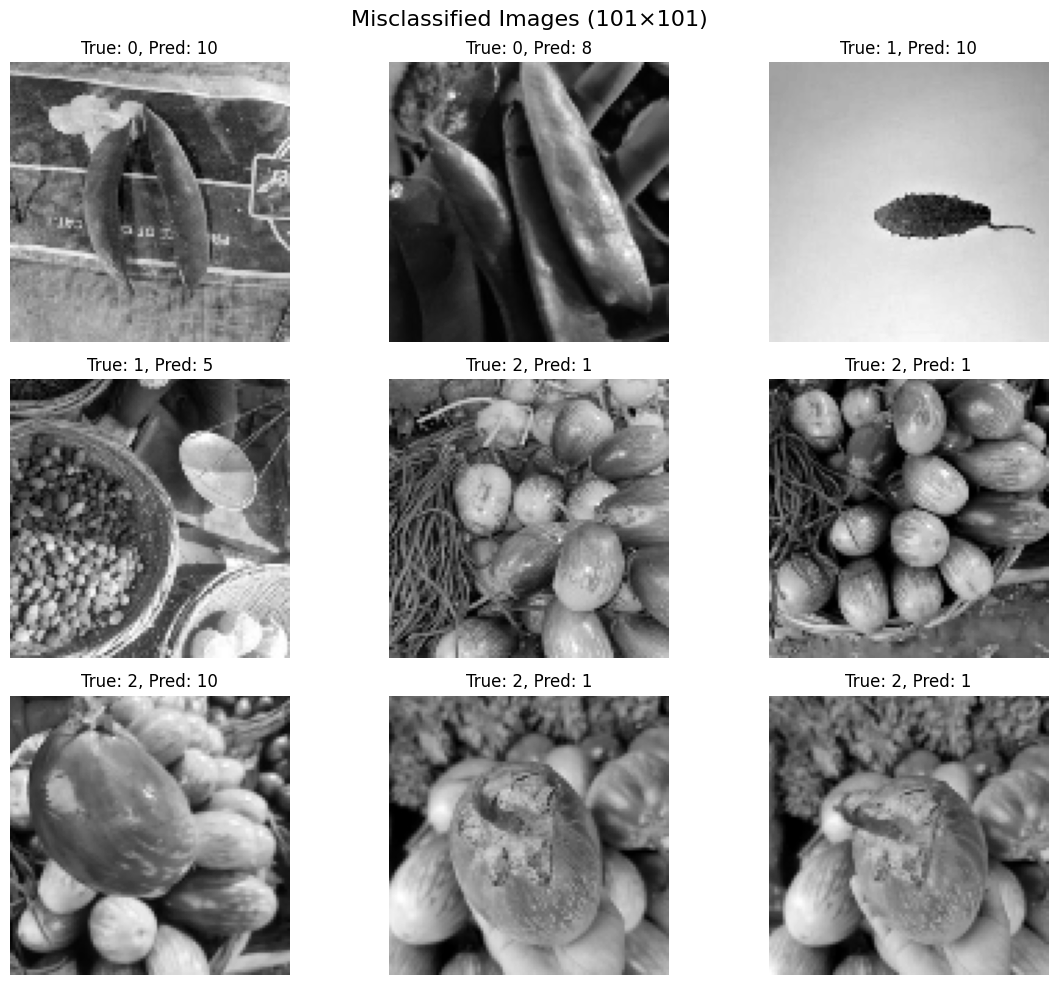

In [12]:
# Get true and predicted labels
y_true_101 = np.concatenate([y.numpy() for x, y in test_101], axis=0)
y_pred_probs_101 = model_101.predict(test_101)
y_pred_101 = np.argmax(y_pred_probs_101, axis=1)
y_true_labels_101 = np.argmax(y_true_101, axis=1)

# Get image data (flattened)
X_images_101 = np.concatenate([x.numpy() for x, y in test_101], axis=0)

# Find misclassified indices
misclassified_idx_101 = np.where(y_pred_101 != y_true_labels_101)[0]

# Plot some misclassified images
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_idx_101[:9]):  # Show first 9
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_images_101[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_true_labels_101[idx]}, Pred: {y_pred_101[idx]}")
    plt.axis('off')

plt.suptitle("Misclassified Images (101×101)", fontsize=16)
plt.tight_layout()
plt.show()

### Final Comparison: 23×23 vs 101×101 Models

Both the **23×23** and **101×101** CNN models achieved **strong classification performance** on the vegetable image dataset, with **test accuracies reaching approximately 92%**. While this similar accuracy may suggest comparable performance at a glance, a deeper analysis reveals important differences in architecture complexity, classification behavior, and suitability.

The **23×23 model** operated on significantly smaller grayscale images. To adapt to the low resolution, the architecture was carefully designed to be shallow but effective — using fewer convolutional blocks and smaller dense layers. This reduced computational cost and training time while still extracting enough structural features (like shape, texture, and outline) for high accuracy. However, this model occasionally struggled to distinguish classes with visually similar outlines or low contrast in grayscale (e.g., **Brinjal vs. Cabbage**), as seen in the misclassified image analysis.

In contrast, the **101×101 model** benefited from **higher-resolution inputs**, which allowed for capturing finer details such as surface texture, subtle shape differences, and contrast variations. To fully utilize this, the model required a **deeper and more complex architecture**, including multiple convolutional layers with increasing filter depths, more regularization (dropout), and larger dense layers. This helped the model better differentiate between **visually overlapping classes** like **Cucumber and Bottle Gourd vs. Cauliflower and Broccoli**, as evidenced by cleaner confusion matrix results and more consistent per-class accuracy.

In conclusion, while **both models are effective**, the **101×101 model shows stronger generalization and robustness**, especially for **visually complex or similar vegetable classes**, albeit at a higher computational cost. The **23×23 model remains a lightweight and efficient alternative**, suitable for resource-constrained environments or applications where quick inference is prioritized over fine-grained accuracy. This comparison illustrates how **input resolution and model depth must be carefully balanced based on the classification task and available resources**.
